In [1]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
from pprint import pprint
import os 
import random
import experiment_helpers as eh
import utils
import ternary
import bisect
sns.set()


In [2]:
data = eh.gather_data('double_quarantine_1112.pkl')

In [3]:
data.keys()

dict_keys(['ba10_2Q', 'fb_artist_2Q'])

In [5]:
len(data['ba10_2Q'])

228753

In [29]:
def group_key(key, ir): 
    # Makes a dict mapping (qprops,..) -> [IR0, IR1, ...]
    datakeys = data[key]
    doc_getter = lambda doc: doc['final_R'] if ir == 'R' else doc['max_I']
    output = {}
    for doc in datakeys:
        k = tuple(doc['quarantine_props'])
        if k not in output:
            output[k] = [] 
        output[k].append(doc_getter(doc))
    return output

def gridify(groups, resolution=0.01, scaledown=1):
    x = y = np.arange(0, 1 + resolution, resolution)
    X,Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    def qprop_to_idx(qprops):
        return [bisect.bisect_left(x, qp) for qp in qprops]
    
    for qprop, vals in groups.items():
        idx = qprop_to_idx(qprop)
        Z[idx[0]][idx[1]] = np.mean(vals) / scaledown
        
    return X, Y, Z
    
        
    
def group_tern(groups):
    output = {} 
    for qprop, vals in groups.items(): 
        output[(round(100 * qprop[0]), round(100 * qprop[1]))] = np.mean(vals) / 50,515
    return output


def data_fixup(group, threshold=0.97):
    int_threshold = round(100 * threshold)
    for i in range(int_threshold, 100):
        for j in range(0, 100 - i):
            print(i, j)

            if (i / 100, j / 100) not in group:
                
                group[(i / 100, j / 100)] = group[(j / 100, i / 100)]
    return group 
    

In [7]:
def get_lower_tri_heatmap(group, cmap=None, scaledown=1):
    cmap = cmap or "YlGnBu"
    grid = gridify(group, scaledown=scaledown)[2]
    mask = np.zeros_like(grid, dtype=np.bool)

    # Want diagonal elements as well
    rows, cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            mask[i][j] = (i  + j > rows-2)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    
    sns_plot = sns.heatmap(grid, mask=mask, square=True, cmap=cmap,
                           xticklabels=10, yticklabels=10)
    
    # save to file
    return f, ax 


In [27]:
def plot_key(key, ir):
    group = group_key(key, ir)
    group = data_fixup(group)
    if key.startswith('ba'): 
        downscale = 10000
    else:
        downscale= 50515
    if ir == 'I':
        cmap = 'YlGnBu'
        title = 'Maximum Number of Infected Vs. Quarantine Thresholds'
    else:
        cmap = 'YlOrRd'
        title = 'Total Number of Infected Vs. Quarantine Thresholds'
    

    f, ax = get_lower_tri_heatmap(group, cmap=cmap, scaledown=downscale)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel("Proportion total infected at first quarantine")
    ax.set_xlabel("Proportion total infected at second quarantine")
    ax.set_title(title)
    sns.set_style("white")
    return f, ax


In [39]:
def best_2q_v_1q(key):
    I_group = data_fixup(group_key(key, 'I'))
    R_group = data_fixup(group_key(key, 'R'))
    
    single_R = float('inf')
    single_I = float('inf')
    for k in R_group:
        if k[0] != 0.0:
            continue 
        if np.mean(R_group[k]) < single_R:
            single_R = np.mean(R_group[k])
            
        if np.mean(I_group[k]) < single_I:
            single_I = np.mean(I_group[k])
    
    double_R = float('inf')
    double_I = float('inf')
    for k in R_group:
        if np.mean(R_group[k]) < double_R:
            double_R = np.mean(R_group[k])
            
        if np.mean(I_group[k]) < double_I:
            double_I = np.mean(I_group[k])
    tups = (single_I, double_I, single_R, double_R)
    if key.startswith('ba'):
        return [_ / 10000 for _ in tups] 
    else:
        return [_/ 50515 for _ in tups]
    

97 0
97 1
97 2
98 0
98 1
99 0


(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f62940a1e10>)

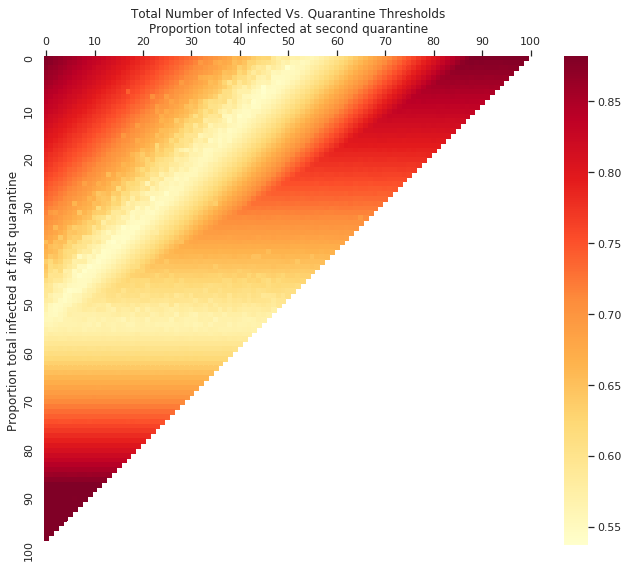

In [40]:
plot_key('fb_artist_2Q', 'R')

97 0
97 1
97 2
98 0
98 1
99 0


(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6294399710>)

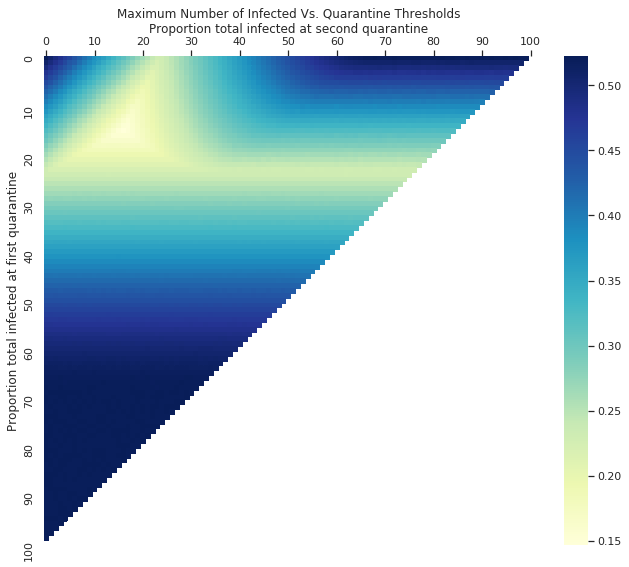

In [32]:
plot_key('fb_artist_2Q', 'I')

97 0
97 1
97 2
98 0
98 1
99 0


(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6294399748>)

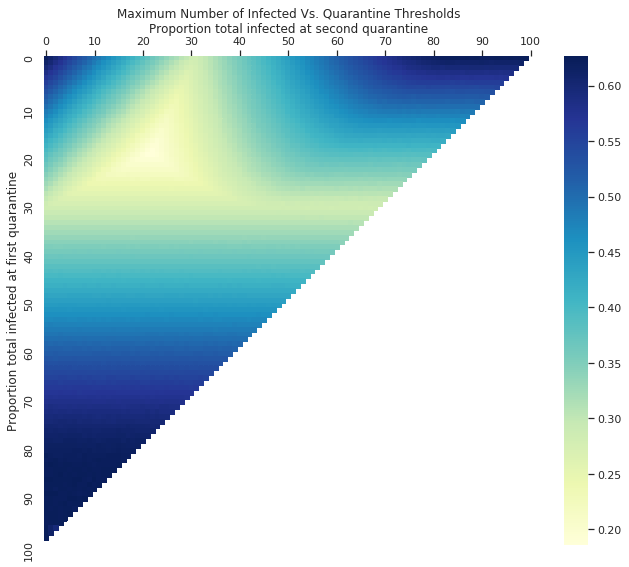

In [33]:
plot_key('ba10_2Q', 'I')

97 0
97 1
97 2
98 0
98 1
99 0


(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f62941b80b8>)

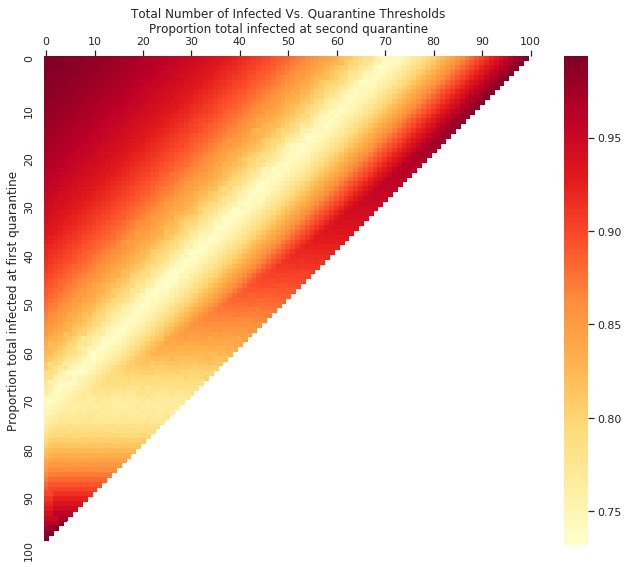

In [34]:
plot_key('ba10_2Q', 'R')

In [41]:
ba_bests = best_2q_v_1q('ba10_2Q')
_bests = best_2q_v_1q('ba10_2Q')

97 0
97 1
97 2
98 0
98 1
99 0
97 0
97 1
97 2
98 0
98 1
99 0
97 0
97 1
97 2
98 0
98 1
99 0
97 0
97 1
97 2
98 0
98 1
99 0


In [48]:
(ba_bests[3] - ba_bests[2]) / ba_bests[2]

-0.0143100364216288

In [44]:
fb_bests = best_2q_v_1q('fb_artist_2Q')


97 0
97 1
97 2
98 0
98 1
99 0
97 0
97 1
97 2
98 0
98 1
99 0


In [47]:
(fb_bests[3] - fb_bests[2]) /fb_bests[2]

-0.036576805465561676